In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Import libraries

In [4]:
import numpy as np
import pandas as pd
import bq_helper
import matplotlib.pyplot as plt
import seaborn as sns

let's get started with Big Query
What is Big Query? See details: <a href='https://medium.com/google-cloud/learning-to-analyze-huge-bigquery-datasets-using-python-on-kaggle-2c6c6153f542'>here</a>

In [5]:
db_london = bq_helper.BigQueryHelper(active_project='bigquery-public-data', dataset_name='london_crime')

Using Kaggle's public dataset BigQuery integration.


In [12]:
# See what tables are involved in database 'db_london'
db_london.list_tables()

# See more details on Google BigQuery in cloud: https://bigquery.cloud.google.com/dataset/bigquery-public-data:london_crime?_ga=2.189454959.-577194880.1523455401

['crime_by_lsoa']

In [13]:
db_london.head('crime_by_lsoa')

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01032740,City of London,Violence Against the Person,Harassment,0,2016,11
1,E01000005,City of London,Violence Against the Person,Harassment,0,2011,3
2,E01032739,City of London,Violence Against the Person,Harassment,0,2016,12
3,E01000005,City of London,Violence Against the Person,Harassment,0,2011,11
4,E01000005,City of London,Violence Against the Person,Harassment,0,2014,3


List of 7 columns and description
* __lsoa_code__: this represents a policing area
* __borough__: the london borough for which the statistic is related
* __major_category__: the major crime category
* __minor_category__: the minor crime category
* __value__: the count of the crime for that particular borough, in that particular month
* __year__: the year of the summary statistic
* __month__: the month of the summary statistic

### How many boroughs are in the table, 'crime_by_lsoa'

In [14]:
# Select columns from the table
boroughs = """
            select distinct borough
            from `bigquery-public-data.london_crime.crime_by_lsoa`;
"""

# Perform the query and store the result
boroughs_result = db_london.query_to_pandas_safe(boroughs)
boroughs_result

,borough
0,City of London
1,Brent
2,Barnet
3,Bexley
4,Camden
5,Ealing
6,Harrow
7,Merton
8,Newham
9,Sutton


### How many lsoa_codes are there per borough

In [24]:
lsoa_codes_per_borough = """
        select borough, count(distinct lsoa_code) as number_of_policing_area
        from `bigquery-public-data.london_crime.crime_by_lsoa`
        group by borough
        order by count(distinct lsoa_code) desc;
"""

codes_per_borough = db_london.query_to_pandas_safe(lsoa_codes_per_borough)
codes_per_borough.head()

,borough,number_of_policing_area
0,Croydon,220
1,Barnet,211
2,Bromley,197
3,Ealing,196
4,Enfield,183


### Average of policing areas per borough

In [27]:
average_lsoa_codes = np.mean(codes_per_borough['number_of_policing_area'])
print('Average of policing areas per borough: {}'.format(round(average_lsoa_codes)))

Average of policing areas per borough: 147


### Plot to see which boroughs are the top 10 policing areas (lsoa codes)

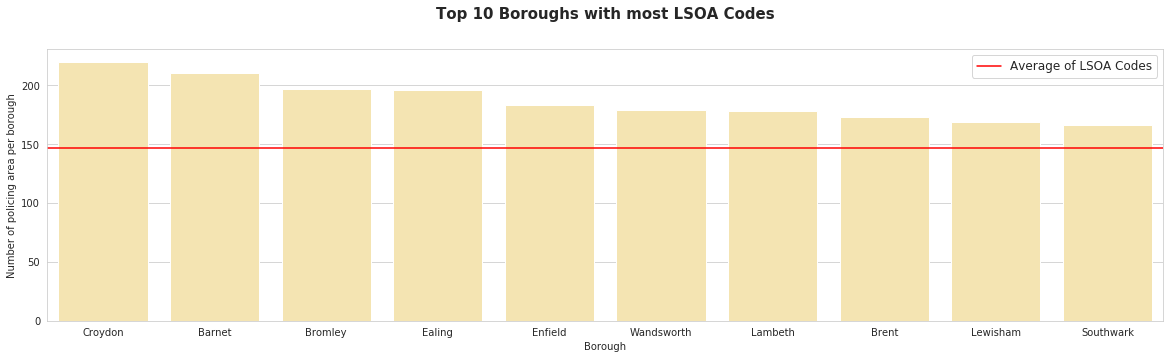

In [30]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(20,5))

sns.barplot(x='borough', y='number_of_policing_area', data=codes_per_borough.head(10), ax=ax, color='#ffeaa7')

plt.axhline(average_lsoa_codes, label='Average of LSOA Codes', color='red')
plt.xlabel('Borough')
plt.ylabel('Number of policing area per borough')
plt.legend(fontsize=12)
plt.title('Top 10 Boroughs with most LSOA Codes', fontsize=15, fontweight='bold', pad=30)

plt.show()

### Total crime in Camden per year and month this time

In [32]:
camden_crime_query = """
        select year, month, sum(value) as total_crime
        from `bigquery-public-data.london_crime.crime_by_lsoa`
        where borough = 'Camden'
        group by year, month;

"""

camden_crime = db_london.query_to_pandas_safe(camden_crime_query)
camden_crime.head()

,year,month,total_crime
0,2015,7,2492
1,2010,7,2610
2,2011,4,2803
3,2016,3,2290
4,2013,9,2271


In [34]:
camden_crime = camden_crime.sort_values(by=['year', 'month'])
camden_crime.head()

,year,month,total_crime
42,2008,1,2610
44,2008,2,2608
79,2008,3,2720
15,2008,4,2532
55,2008,5,2680


In [36]:
camden_crime.index

Int64Index([ 42,  44,  79,  15,  55,  10,  52,  20, 101,  21,
            ...
              3,  23,  39, 100,  99,  54,  18,  97,  81,  53],
           dtype='int64', length=108)

Index is currently basic. We need to have the table data indexed by a date for easier manipulation. Let's convert the year & month info to a datetime format.

In [38]:
camden_crime['date'] = pd.to_datetime(camden_crime.year.map(str) + '-' + camden_crime.month.map(str), format='%Y-%m')
camden_crime.set_index('date', inplace=True)
camden_crime.head()

,year,month,total_crime
date,,,
2008-01-01,2008,1,2610
2008-02-01,2008,2,2608
2008-03-01,2008,3,2720
2008-04-01,2008,4,2532
2008-05-01,2008,5,2680


### Plot with the above data table

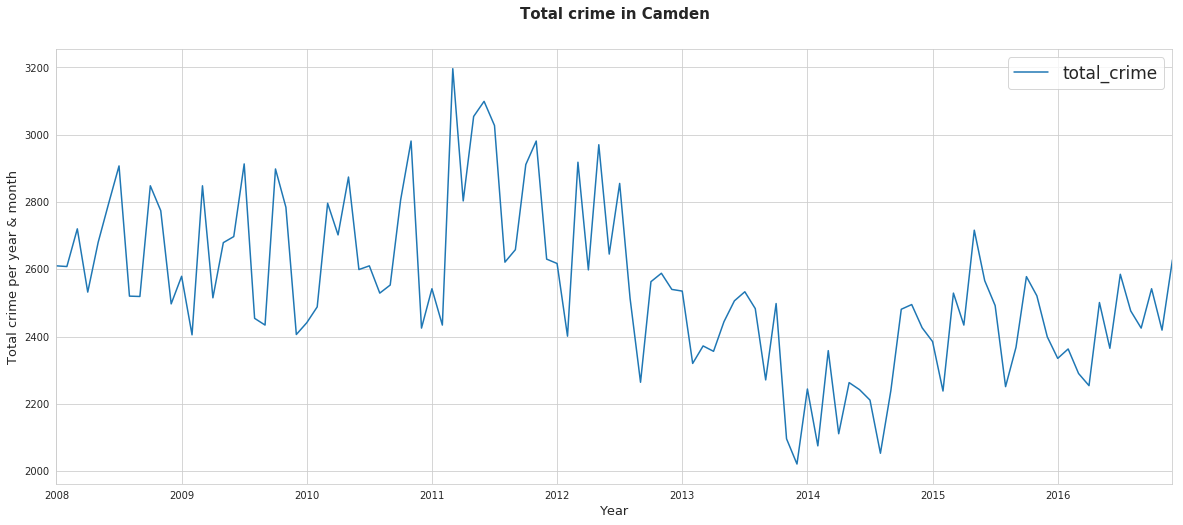

In [44]:
plt.figure(figsize=(20,8))
camden_crime.total_crime.plot()

plt.title('Total crime in Camden', fontsize=15, fontweight='bold', pad=30)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Total crime per year & month', fontsize=13)
plt.legend(fontsize=17)

plt.show()

Result: apparently, total crime per year & month is reported the most between 2011 to 2012.

### Zoom up the particular year part

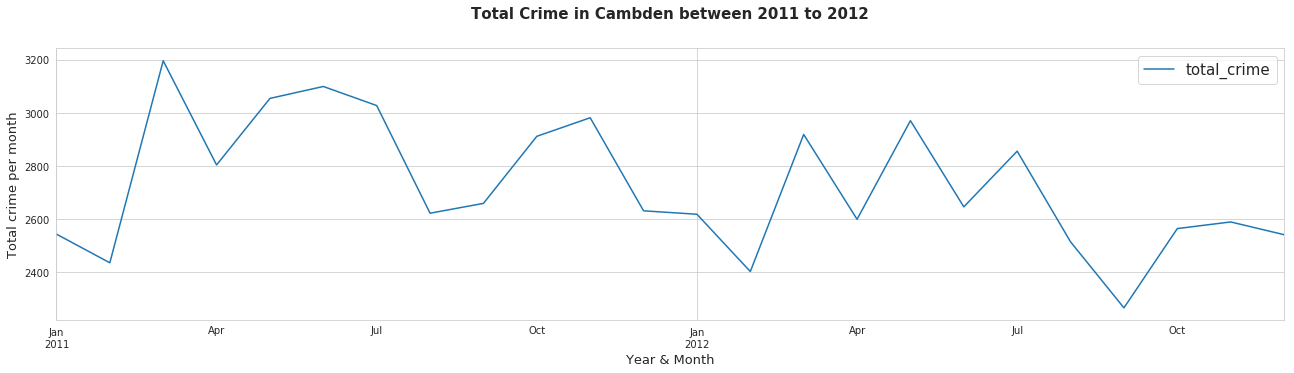

In [51]:
crime_2011_to_2012 = camden_crime.loc['2011':'2012',]

plt.figure(figsize=(22,5))
crime_2011_to_2012.total_crime.plot()

plt.title('Total Crime in Cambden between 2011 to 2012', fontsize=15, fontweight='bold', pad=30)
plt.xlabel('Year & Month', fontsize=13)
plt.ylabel('Total crime per month', fontsize=13)
plt.legend(fontsize=15)

plt.show()

### Data subsetted by the type of crime

In [54]:
camden_type_crime_query = """
        select year, month, major_category, sum(value) as total_crime
        from `bigquery-public-data.london_crime.crime_by_lsoa`
        where borough = 'Camden'
        group by year, month, major_category
        order by year, month;
"""

df_camden_type_crime = db_london.query_to_pandas_safe(camden_type_crime_query)
df_camden_type_crime.head()

,year,month,major_category,total_crime
0,2008,1,Sexual Offences,13
1,2008,1,Violence Against the Person,413
2,2008,1,Drugs,218
3,2008,1,Theft and Handling,1272
4,2008,1,Other Notifiable Offences,23


In [55]:
# Let's replace the year and month with datetime format 
df_camden_type_crime['date'] = pd.to_datetime(df_camden_type_crime.year.map(str) + '-' + df_camden_type_crime.month.map(str), format='%Y-%m')

df_camden_type_crime.drop(columns = ['year', 'month'], inplace=True)
df_camden_type_crime.head()

,major_category,total_crime,date
0,Sexual Offences,13,2008-01-01
1,Violence Against the Person,413,2008-01-01
2,Drugs,218,2008-01-01
3,Theft and Handling,1272,2008-01-01
4,Other Notifiable Offences,23,2008-01-01


In [64]:
# pandas.DataFrame.pivot: Return reshaped DataFrame organized by given index / column values
pivot_type_crime_camden = df_camden_type_crime.pivot(index='date', columns = 'major_category', values='total_crime')
pivot_type_crime_camden.head()

major_category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
date,,,,,,,,,
2008-01-01,323,223,218,62,23,63,13,1272,413
2008-02-01,291,192,410,61,42,60,23,1092,437
2008-03-01,301,255,335,0,41,71,0,1216,501
2008-04-01,268,223,299,0,32,90,0,1136,484
2008-05-01,288,253,351,0,38,73,0,1138,539


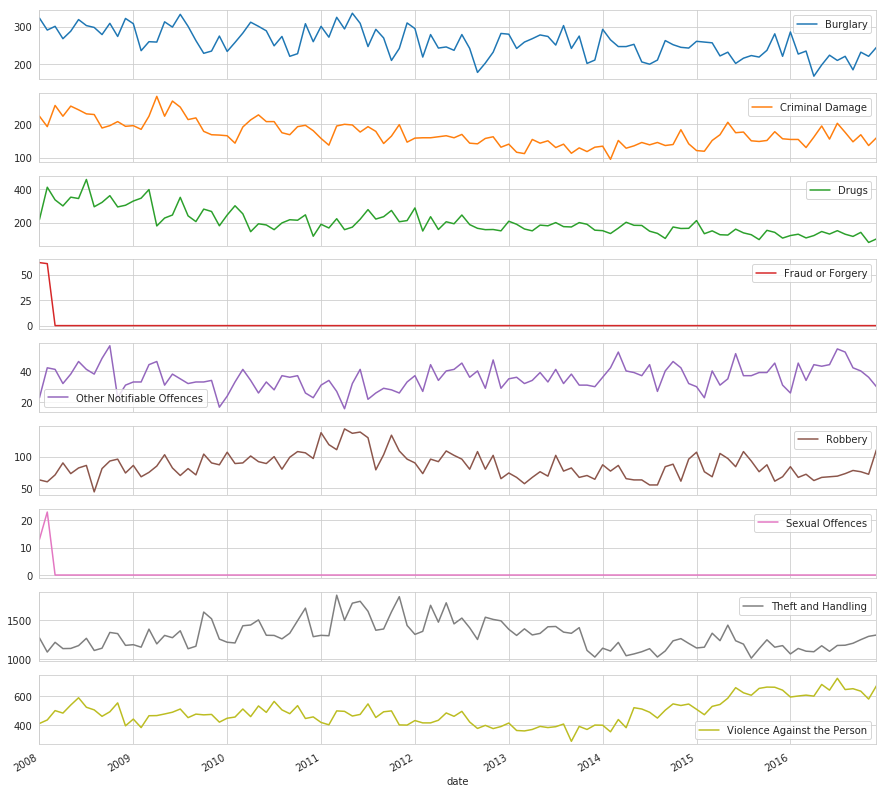

In [65]:
# plot
pivot_type_crime_camden.plot(subplots=True, figsize=(15,15))
plt.show()

### What type of crimes are growing recently?

In [68]:
growing_query = """
        select year, major_category, sum(value) as total_crime
        from `bigquery-public-data.london_crime.crime_by_lsoa`
        group by year, major_category
        order by year, major_category
"""

df_growing_crime = db_london.query_to_pandas_safe(growing_query)
df_growing_crime

,year,major_category,total_crime
0,2008,Burglary,88092
1,2008,Criminal Damage,91872
2,2008,Drugs,68804
3,2008,Fraud or Forgery,5325
4,2008,Other Notifiable Offences,10112
...,...,...,...
76,2016,Other Notifiable Offences,15809
77,2016,Robbery,22528
78,2016,Sexual Offences,0
79,2016,Theft and Handling,294133


In [71]:
# convert the year to datetime format and reset the index
df_growing_crime['year'] = pd.to_datetime(df_growing_crime.year, format='%Y')
df_growing_crime.set_index(df_growing_crime['year'], inplace=True)
df_growing_crime.drop(columns=['year'], inplace=True)

df_growing_crime.head()

,major_category,total_crime
year,,
2008-01-01,Burglary,88092
2008-01-01,Criminal Damage,91872
2008-01-01,Drugs,68804
2008-01-01,Fraud or Forgery,5325
2008-01-01,Other Notifiable Offences,10112


### Subplots
Make separate subplots for each column

In [75]:
# Pivot the dataframe df_growing_crime
pivot_growing_crime = df_growing_crime.pivot(columns='major_category', values='total_crime')
pivot_growing_crime.head()

major_category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person
year,,,,,,,,,
2008-01-01,88092,91872,68804,5325,10112,29627,1273,283692,159844
2009-01-01,90619,85565,60549,0,10644,29568,0,279492,160777
2010-01-01,86826,77897,58674,0,10768,32341,0,290924,157894
2011-01-01,93315,70914,57550,0,10264,36679,0,309292,146901
2012-01-01,93392,62158,51776,0,10675,35260,0,334054,150014


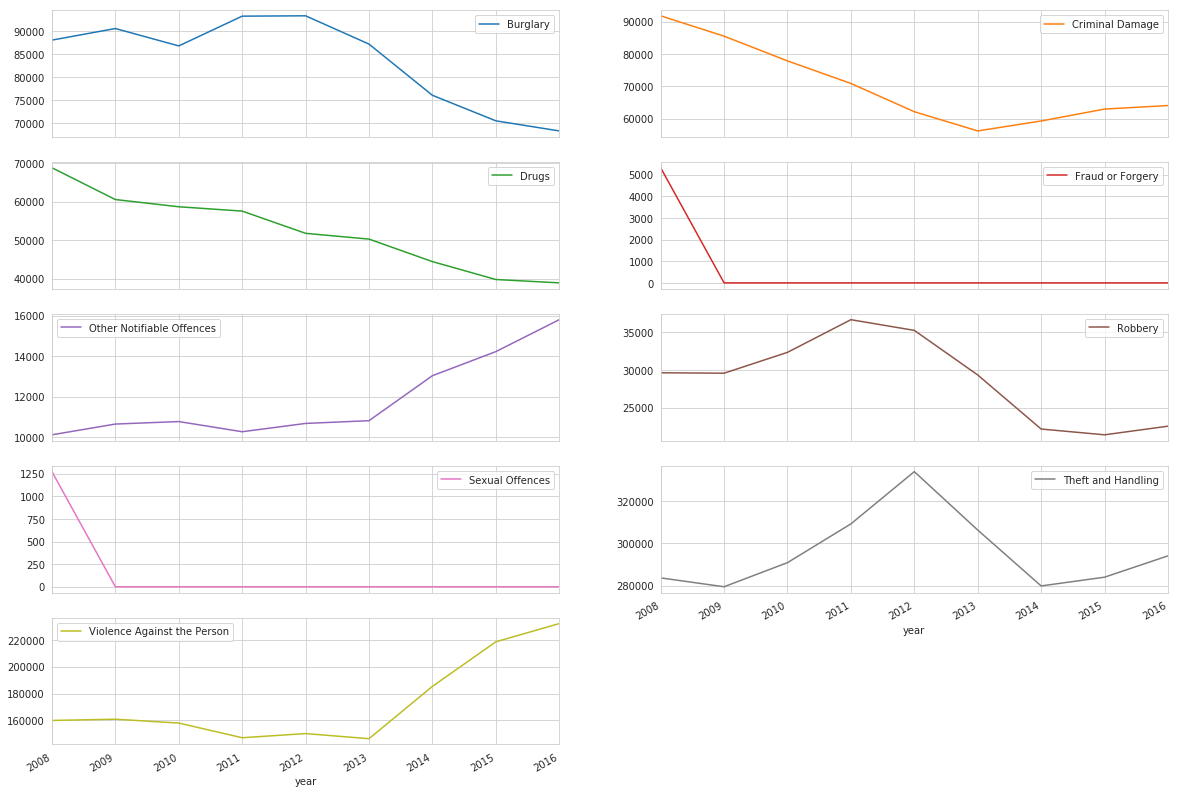

In [76]:
# Subplot
pivot_growing_crime.plot(subplots=True, figsize=(20,15), layout=(5,2))    # layout : tuple (optional) (rows, columns) for the layout of subplots
plt.show()